# TODO idempotence
# requirements.txt

# Immothep

## 1. Loading Data and Packages

In [31]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import modules.main as api
from modules.loader import DataLoader
from modules.estimate import Estimate

IN_LOCAL_PATH = '../data/IN/'
OUT_LOCAL_PATH = '../data/OUT/'

dl = DataLoader()
estimate = Estimate()

def missing_data(df): 
    '''Show missing data'''
    print(f'Dataset size is : {df.shape}')
    # Find Missing Ratio of Dataset
    all_data_na = (df.isnull().sum() / len(df)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
    print(missing_data)
    # Percent missing data by feature
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x=all_data_na.index, y=all_data_na)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)

def outlier_identification(df, column):
    '''Outliers identification with 1.5 x IQR Rule'''
    sorted(column)
    # 25, 75 : à changer comme tu veux
    Q1, Q3 = np.percentile(df[column], [25, 75]) 
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    
    # Je triche pour le prix
    if (column == 'price' and lower_range < 10000):
        lower_range = 10000

    print(f'{column}: [{lower_range} - {upper_range}]')

    return df[(df[column] > lower_range) & (df[column] < upper_range)]

def zip(df, zip):
    '''Select property only on the given zipcode and display the corr'''
    df = df[df.zip == zip]
    df = df.drop(['zip'], axis=1)
    print(df.corr())

    return df

def dep(df, dep):
    '''Display the most expensive city inside a specified department'''
    dep_df = df[df.dep == dep]
    dep_df['zip'] = dep_df['zip'].astype(str)
    dep_corr = dep_df.zip.str.get_dummies().corrwith(dep_df.price / dep_df.price.max()).sort_values(ascending=False)
    print(dep_corr)

    return df

def rooms(df):
    '''Display the number of rooms'''
    df.rooms.value_counts().plot(kind='bar', title='Number of rooms')
    plt.xlabel('Rooms')
    plt.ylabel('Count')

def scatter(df, column1, column2):
    plt.scatter(df[column1], df[column2])
    plt.xlabel('Price')
    plt.ylabel('Rooms')

def linear_regression(df):
    labels = df['price']
    train = df.drop(['price', 'dep'], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(train, labels, test_size=0.20, random_state=0)
    reg = LinearRegression()
    reg.fit(x_train, y_train)
    print(reg.score(x_test, y_test))

    return reg

def random_forest(df):
    labels = df['price']
    train = df.drop(['price', 'dep'], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(
        train, labels, test_size=0.20, random_state=0)
    reg = RandomForestRegressor(n_estimators=10, random_state=0, min_samples_leaf=5)
    reg.fit(x_train, y_train)
    print(reg.score(x_test, y_test))

    return reg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
dl.split_data('valeursfoncieres-2019.txt', '|', 'Nature mutation', ['Vente'])

<AxesSubplot:title={'center':'Type repatition'}, ylabel='type'>

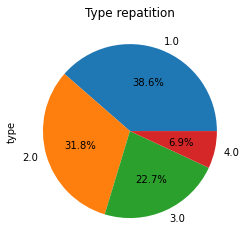

In [32]:
sale_df = pd.read_csv(f'{OUT_LOCAL_PATH}Vente.csv', sep='|', decimal=',', encoding='UTF-8', usecols=['Valeur fonciere', 'Code postal', 'Code departement', 'Code type local', 'Surface reelle bati', 'Nombre pieces principales'], dtype={'Code department': str})
sale_df.columns = ['price', 'zip', 'dep', 'type', 'landing_area', 'rooms']
sale_df['type'].value_counts().plot(kind='pie', title='Type repatition', autopct='%.1f%%')

We'll keep only type 1 (house) and 2 (apartment) 

In [33]:
house_df = sale_df[sale_df.type == 1]
apartment_df = sale_df[sale_df.type == 2]
house_df = house_df.drop(['type'], axis=1)
apartment_df = apartment_df.drop(['type'], axis=1)

## 2. Clean Data

Dataset size is : (512831, 5)
              Missing Ratio
price              0.270849
zip                0.008580
rooms              0.001950
landing_area       0.001950


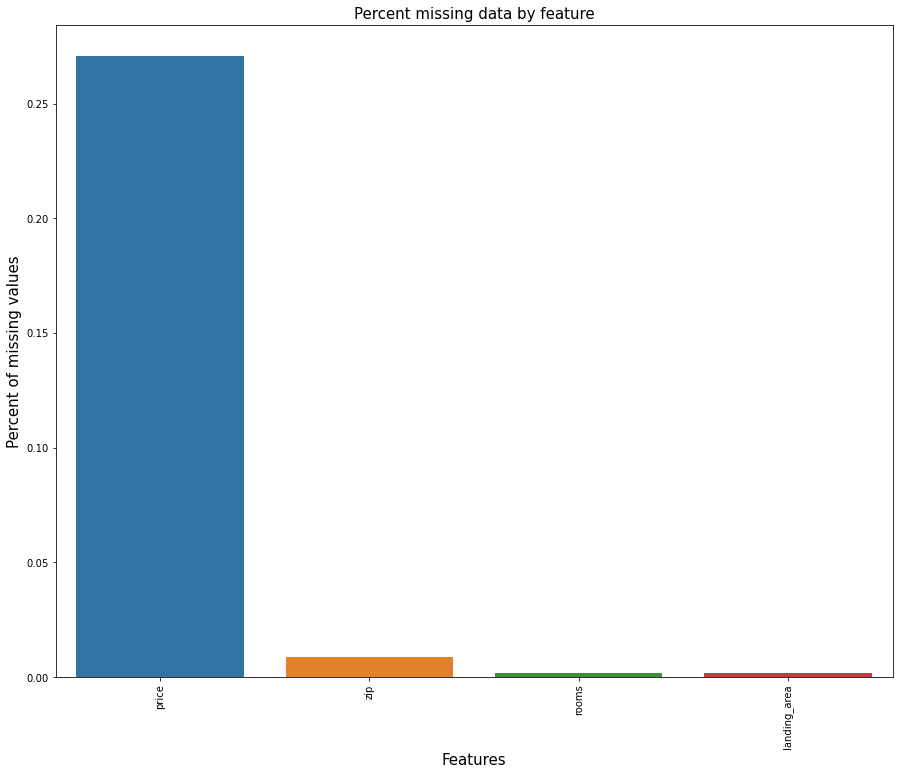

In [34]:
missing_data(house_df)

Dataset size is : (422134, 5)
              Missing Ratio
price              0.525662
rooms              0.001895
landing_area       0.001895
zip                0.001895


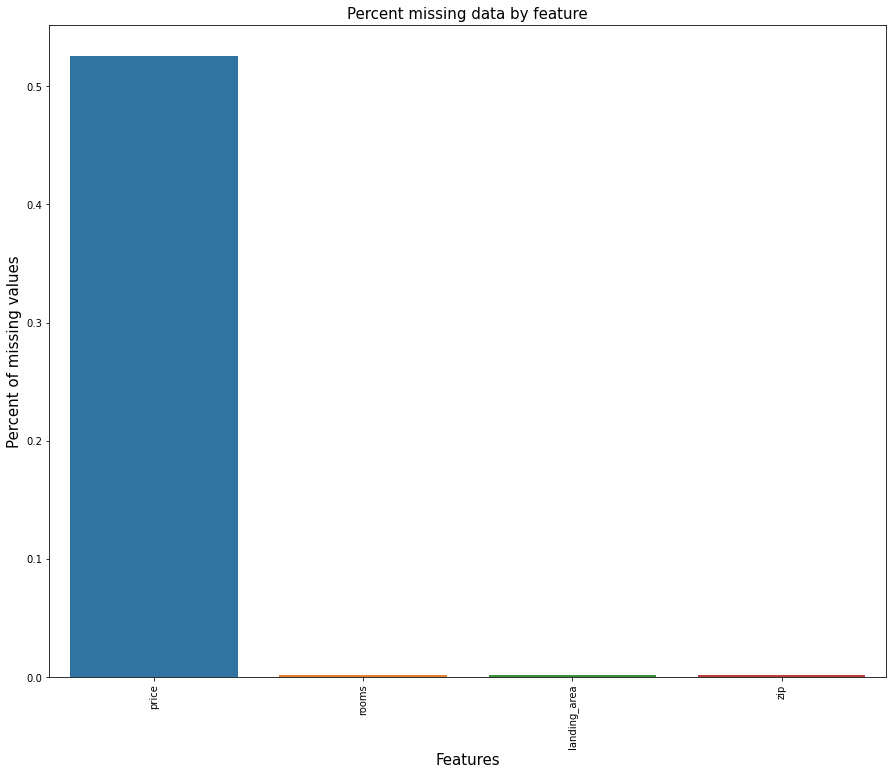

In [35]:
missing_data(apartment_df)

In [36]:
house_df = house_df.dropna(subset=['price', 'zip', 'rooms', 'landing_area'])
apartment_df = apartment_df.dropna(subset=['price', 'zip', 'rooms', 'landing_area'])

In [37]:
print(f'House dataset size is now: {house_df.shape}')
print(f'Apartment dataset size is now: {apartment_df.shape}')

House dataset size is now: (511388, 5)
Apartment dataset size is now: (419899, 5)


In [38]:
house_clf_df = zip(house_df, 63000)
# It appears that some apartments belong to the same building and was sold together at the same price, let's group them to have the real area and number of rooms bought at this price.
apartment_df = apartment_df.groupby(['price', 'zip', 'dep']).sum().reset_index()
apartment_clf_df = zip(apartment_df, 63000)

                 price  landing_area     rooms
price         1.000000      0.682559  0.474955
landing_area  0.682559      1.000000  0.799618
rooms         0.474955      0.799618  1.000000
                 price  landing_area     rooms
price         1.000000      0.298118  0.204625
landing_area  0.298118      1.000000  0.977900
rooms         0.204625      0.977900  1.000000


The correlation is much better when we stick on a specified city which is logic because the same property will not cost the same if you are in a big city than a small one.

Outliers identification with 1.5 x IQR Rule


In [39]:
house_df = outlier_identification(house_df, 'rooms')
house_df = outlier_identification(house_df, 'price')
house_df = outlier_identification(house_df, 'landing_area')

apartment_df = outlier_identification(apartment_df, 'rooms')
apartment_df = outlier_identification(apartment_df, 'price')
apartment_df = outlier_identification(apartment_df, 'landing_area')

rooms: [0.0 - 8.0]
price: [10000 - 517703.125]
landing_area: [8.0 - 184.0]
rooms: [-2.5 - 9.5]
price: [10000 - 502500.0]
landing_area: [-27.5 - 160.5]


In [40]:
print(f'House dataset size is now: {house_df.shape}')
print(f'Apartment dataset size is now: {apartment_df.shape}')

House dataset size is now: (451534, 5)
Apartment dataset size is now: (162400, 5)


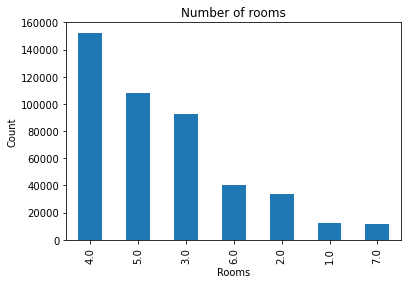

In [41]:
rooms(house_df)

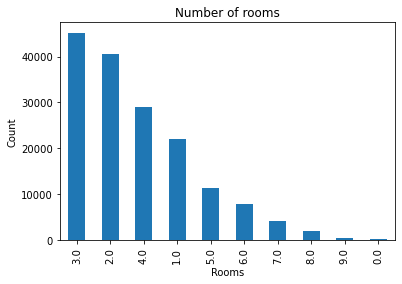

In [42]:
rooms(apartment_df)

### Puy-de-Dôme
Visualizing the location of the houses.

In [43]:
dep(house_df, 63)

63800.0    0.161872
63400.0    0.151568
63000.0    0.140208
63200.0    0.137433
63122.0    0.114444
             ...   
63560.0   -0.083106
63330.0   -0.083511
63220.0   -0.083956
63570.0   -0.086124
63700.0   -0.151878
Length: 97, dtype: float64


,price,zip,dep,landing_area,rooms
3,209000.0,1160.0,1,90.0,4.0
4,134900.0,1370.0,1,101.0,5.0
5,192000.0,1340.0,1,88.0,4.0
6,45000.0,1250.0,1,39.0,2.0
13,116000.0,1560.0,1,100.0,1.0
...,...,...,...,...,...
2278603,390000.0,75015.0,75,43.0,2.0
2279423,298200.0,75015.0,75,113.0,4.0
2295069,456000.0,75018.0,75,58.0,3.0
2298058,355000.0,75018.0,75,42.0,2.0


In [44]:
dep(apartment_df, 63)

63400.0    0.188649
63000.0    0.092092
63510.0    0.050679
63870.0    0.048700
63118.0    0.048263
             ...   
63140.0   -0.066954
63240.0   -0.070242
63700.0   -0.071378
63300.0   -0.100535
63150.0   -0.138735
Length: 62, dtype: float64


,price,zip,dep,landing_area,rooms
1421,10001.0,42000.0,42,58.0,2.0
1422,10138.0,65130.0,65,33.0,2.0
1423,10200.0,75014.0,75,36.0,2.0
1424,10200.0,88800.0,88,80.0,4.0
1425,10340.0,75018.0,75,11.0,1.0
...,...,...,...,...,...
188559,502250.0,44500.0,44,66.0,3.0
188560,502250.0,94300.0,94,47.0,2.0
188561,502290.0,95600.0,95,30.0,2.0
188562,502400.0,75017.0,75,34.0,2.0


As we can see, Chamalières (63400) is the most expensive city in 63 which is representative of the reality both for houses and apartments.

In [45]:
house_clf_df.corr()

,price,landing_area,rooms
price,1.000000,0.682559,0.474955
landing_area,0.682559,1.000000,0.799618
rooms,0.474955,0.799618,1.000000


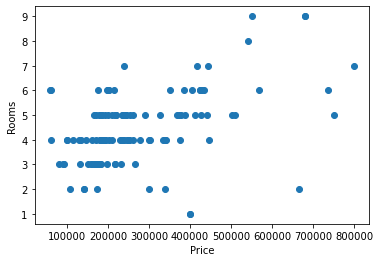

In [46]:
# Number of rooms vs Sale Price
scatter(house_clf_df, 'price', 'rooms')

In [47]:
apartment_clf_df.corr()

,price,landing_area,rooms
price,1.000000,0.298118,0.204625
landing_area,0.298118,1.000000,0.977900
rooms,0.204625,0.977900,1.000000


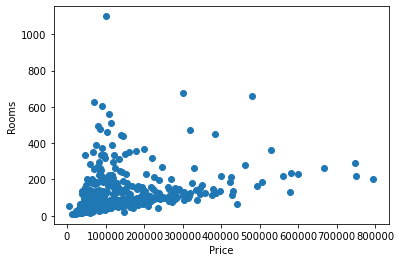

In [48]:
# Living Area vs Sale Price
scatter(apartment_clf_df, 'price', 'landing_area')

## 6. Modeling and Predictions


In [49]:
linear_regression(house_df)
linear_regression(apartment_df)

0.14832281034601424
0.1139050929797113


LinearRegression()

The score of the linear regression is very low, let's try with a random forest to improve the score.

In [50]:
linear_regression(house_clf_df)
linear_regression(apartment_clf_df)

0.5350636617056602
0.29936266814406554


LinearRegression()

The score is better when we stick on a specified city which is logic because the same property will not cost the same if you are in a big city than a small one. Let's try with a random forest.

In [51]:
print('House: ')
pickle.dump(random_forest(house_df), open(f'{OUT_LOCAL_PATH}house.pkl', 'wb'))
print('Apartment: ')
pickle.dump(random_forest(apartment_df), open(f'{OUT_LOCAL_PATH}apartment.pkl', 'wb'))

House: 
0.5835793159865525
Apartment: 
0.5515725197925792


## 7. API

In [52]:
def api(rooms, area, zip):
    query = {'metre_carre': area, 'nb_pieces': rooms, 'code_postal': zip}
    response = requests.get(f'http://127.0.0.1:5003/api/estimate/', params=query)
    print(response.json())

In [54]:
api(3, 115, 75016)

{'estimation_house': 310682.01130952383, 'estimation_apartment': 298581.4308199634}
